In [1]:
import functools
import jax
import os
import html

from datetime import datetime
from jax import numpy as jp
jax.config.update("jax_debug_nans", False)
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output, display

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html

import shutil

from src.pods.Pods import train as train_pods
from src.hds.Hds import train as train_hds
from src.env.Pendulum import InvertedPendulum
import pickle




In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print(jax.devices())

gpu
[cuda(id=0)]


In [3]:
env = InvertedPendulum(target=jp.array([1]))
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

#HTML(html.render(env.sys, [state.pipeline_state]))

In [4]:
ckpt_dir = './tmp/flax_ckpt'

if os.path.exists(ckpt_dir):
    shutil.rmtree(ckpt_dir)  # Remove any existing checkpoints from the last notebook run.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
ticker.EngFormatter.ENG_PREFIXES.update({9:"B"}) # For cleaner formatting


from scipy.stats import trim_mean, bootstrap

sns.set()

In [6]:
import pandas as pd
def progress_f(x_data,y_data,seed):
    clear_output(wait=True)
    plt.xlabel('epoch')
    plt.ylabel('total reward')
    plt.plot(x_data, y_data)
    plt.show()


    data = {'epoch': x_data, f'{seed}': y_data}
    new_data = pd.DataFrame(data)
    file_path='podsdata.txt'
    if os.path.exists(file_path):
        existing_data = pd.read_csv(file_path)
        if 'epoch' not in existing_data.columns:
            existing_data['epoch'] = new_data['epoch']
        if f'{seed}' in existing_data.columns:
            existing_data = existing_data.drop(columns=[f'{seed}'])
        existing_data = pd.merge(existing_data, new_data, on='epoch', how='outer')
    else:
        existing_data = new_data
    
    existing_data.to_csv(file_path, index=False)



#policy = train_hds(env,trajectory_length=50 ,num_samples=200,epochs=20, inner_epochs=30, alpha_a= 5e-3, init_learning_rate=1e-2, init_noise=0.0, noise_decay=0.5, progress_fn=progress_f) 
for i in range(25,25):
    policy = train_pods(env,trajectory_length=50 ,num_samples=200,epochs=50, inner_epochs=20, alpha_a=5e-4, init_learning_rate=1e-2, progress_fn=progress_f, seed =i, gradplot=False)
progress_fn=progress_f

In [7]:
import pandas as pd
def progress_f(x_data,y_data,seed):

    clear_output(wait=True)
    plt.xlabel('epoch')
    plt.ylabel('gradient of reward')
    plt.plot(x_data, y_data)
    plt.show()

    data = {'trajectorylength': x_data, f'{seed}': y_data}
    new_data = pd.DataFrame(data)
    file_path='podsgraddata.txt'
    if os.path.exists(file_path):
        existing_data = pd.read_csv(file_path)
        if 'trajectorylength' not in existing_data.columns:
            existing_data['trajectorylength'] = new_data['trajectorylength']
        if f'{seed}' in existing_data.columns:
            existing_data = existing_data.drop(columns=[f'{seed}'])
        existing_data = pd.merge(existing_data, new_data, on='trajectorylength', how='outer')
    else:
        existing_data = new_data
    
    existing_data.to_csv(file_path, index=False)



#policy = train_hds(env,trajectory_length=50 ,num_samples=200,epochs=20, inner_epochs=30, alpha_a= 5e-3, init_learning_rate=1e-2, init_noise=0.0, noise_decay=0.5, progress_fn=progress_f) 

for i in range(25,25):
    policy = train_pods(env,trajectory_length=70 ,num_samples=128,epochs=1, inner_epochs=30, alpha_a=5e-4, init_learning_rate=1e-2, progress_fn=progress_f, seed =i,  gradplot=True)

progress_fn=progress_f

<function matplotlib.pyplot.show(close=None, block=None)>

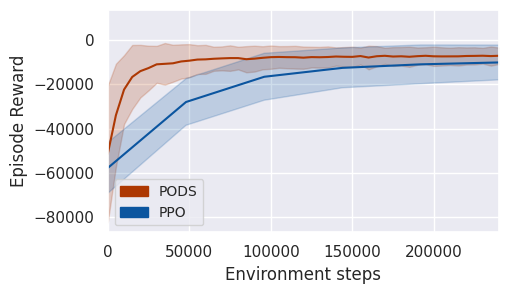

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
blues = sns.color_palette("Blues")
oranges = sns.color_palette("Oranges")
PODS = mpatches.Patch(color=oranges[-1], label='PODS')
PPO = mpatches.Patch(color=blues[-1], label='PPO')
fancy_legend = [PODS, PPO]


f, ax = plt.subplots(1, 1, sharey=False, figsize=(5.25,3.1))
# Read the data from the file
file_path = 'podsdata.txt'
data = pd.read_csv(file_path)
data['epoch'] = data['epoch'] 
# Calculate the mean and standard deviation across each row (excluding the 'epoch' column)
data_mean = data.drop(columns=['epoch']).mean(axis=1)
data_std = data.drop(columns=['epoch']).std(axis=1)

# Plot the mean and fill between the std
ax.plot(data['epoch'], data_mean, c=oranges[-1])
ax.fill_between(data['epoch'], data_mean - data_std, data_mean + data_std, alpha=0.2, color=oranges[-1], label='Standard Deviation')

file_path_ppo = 'ppodata.txt'  # Replace with the actual file path for PPO data
data_ppo = pd.read_csv(file_path_ppo)
data_ppo['epoch'] = data_ppo['epoch']

# Calculate the mean and standard deviation for PPO
data_ppo_mean = data_ppo.drop(columns=['epoch']).mean(axis=1)
data_ppo_std = data_ppo.drop(columns=['epoch']).std(axis=1)

# Plot the PPO data
ax.plot(data_ppo['epoch'], data_ppo_mean, c=blues[-1])
ax.fill_between(data_ppo['epoch'], data_ppo_mean - data_ppo_std, data_ppo_mean + data_ppo_std, alpha=0.2, color=blues[-1])


ax.set_xlabel("Environment steps")
ax.set_xlim(0,240000)


# Final cleanup
ax.set_ylabel("Episode Reward")
plt.tight_layout()

# Create fancy legend
ax.legend(handles=fancy_legend, ncol=1, fontsize='small')
# plt.tight_layout()

plt.savefig("podsvsppo.pdf", bbox_inches="tight", pad_inches=0)
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

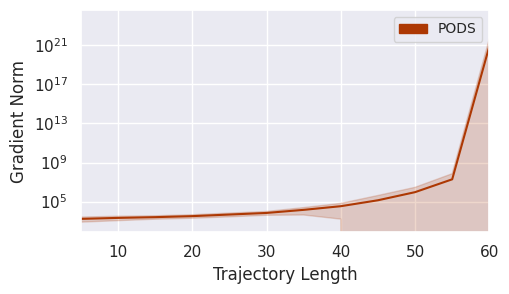

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
blues = sns.color_palette("Blues")
oranges = sns.color_palette("Oranges")
PODS = mpatches.Patch(color=oranges[-1], label='PODS')
PPO = mpatches.Patch(color=blues[-1], label='PPO')
fancy_legend = [PODS]


f, ax = plt.subplots(1, 1, sharey=False, figsize=(5.25,3.1))
# Read the data from the file
file_path = 'podsgraddata.txt'
data = pd.read_csv(file_path)
data['trajectorylength'] = data['trajectorylength'] 
# Calculate the mean and standard deviation across each row (excluding the 'epoch' column)
data_mean = data.drop(columns=['trajectorylength']).mean(axis=1)
data_std = data.drop(columns=['trajectorylength']).std(axis=1)

# Plot the mean and fill between the std
ax.plot(data['trajectorylength'], data_mean, c=oranges[-1])
ax.fill_between(data['trajectorylength'], data_mean - data_std, data_mean + data_std, alpha=0.2, color=oranges[-1], label='Standard Deviation')

ax.set_yscale('log')  # Set logarithmic scale

ax.set_xlabel("Trajectory Length")
ax.set_xlim((5,60))
#ax.set_ylim((-100,200000))

# Final cleanup
ax.set_ylabel("Gradient Norm")
plt.tight_layout()

# Create fancy legend
ax.legend(handles=fancy_legend, ncol=1, fontsize='small')
# plt.tight_layout()

plt.savefig("podsgradientnorm.svg", bbox_inches="tight", pad_inches=0)
plt.show


In [10]:
f = open("reward.txt", "w")
g = open("actions.txt", "w")
inference_fn = policy()
rollout = []
rng = jax.random.PRNGKey(seed=1)
state = env.reset(rng=rng)
reward = []
actions = []
for _ in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  #print(state.obs)
  act = inference_fn(state.obs)
  print(act)
  reward.append(state.reward)
  state = env.step(state, act)
  #print(state.reward)
  actions.append(act)

  
print(reward, file=f)
print(actions, file=g)

NameError: name 'policy' is not defined

In [ ]:
yes=html.render(env.sys.replace(), rollout)
with open("data.html", "w") as file:
    file.write(yes)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
y = np.array([-1179.7744147521037, -1181.469804906773, -1183.2904349841435, -1187, -1182, -1195.431279810023, -1195.1392120290, -1188.6893949388361, -1194.4963082456286, -1201.8986226458867, -1198.973976637499])
a, b = np.polyfit(x, y, 1)

plt.figure(figsize=(12, 5), dpi=1000)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 14
plt.rcParams['axes.linewidth'] = 2  # Increase border thickness
plt.suptitle('Mean Total Reward across Aggregation Factors')

plt.grid(True)
plt.grid(which='minor', linestyle='-', linewidth=0.1, color='black')
plt.grid(which='major', linestyle='-', linewidth=0.5, color='black')
plt.minorticks_on()

plt.xlim(-0.05, 1.05)
plt.ylim(-1205, -1175)

plt.plot(x, y, 'x', label='Original data', markersize=10, markeredgewidth=2, color='blue')
plt.plot(x, a*x + b, 'r', label='Fitted line', linewidth=3)  # Increase line thickness

plt.xlabel('Aggregation Factor')
plt.ylabel('Average Total Reward')

plt.legend(loc='upper center', frameon=False, ncol=2, bbox_to_anchor=(0.5, 1.1), fontsize=10)
plt.savefig("aggregation_factor.svg", format="svg")

plt.show()
